> Probably want to write a Python package after 476 ends since I have idea how to use Excel. Here is an implementation of sBG though, for modeling discrete-time, contractional behaviour. Wish I had more time to clean up this shit.

In [13]:
import numpy as np
import pandas as pd
import os
from IPython.display import display, Image
from scipy.optimize import minimize
import plotly.graph_objs as go

In [1]:
def compute_probabilities(alpha, beta, num_periods):
    '''Compute the probability of a random person churning for each time period'''
    p = [alpha / (alpha + beta)]
    for t in range(2, num_periods + 1):
        p.append((beta+t-2) / (alpha+beta+t-1) * p[t-2])
    return p


def pct_dying(data, num_periods):
    '''Compute the number of people who churn for each time period'''
    n = [1 - data[0]]
    for t in range(1, num_periods):
        n.append(data[t - 1] - data[t])
    return n


def log_likelihood(alpha, beta, data):
    '''Objective function that we need to maximize to get best alpha and beta parameters
    **Computed log-likelihood will be 1/n smaller than the actual log-likelihood (n = original sample size)**
    '''
    if alpha <= 0 or beta <= 0:
        return -99999
    probabilities = np.array(compute_probabilities(alpha, beta, len(data)))
    percent_dying = np.array(pct_dying(data, len(data)))
    
    return np.sum(np.log(probabilities) * percent_dying) + data[-1] * np.log(1 - np.sum(probabilities))


def maximize(data):
    '''Maximize log-likelihood by searching for best (alpha, beta) combination'''
    func = lambda x: -log_likelihood(x[0], x[1], data) # x is a tuple (alpha, beta)
    x0 = np.array([100., 100.])
    res = minimize(func, x0, method='Nelder-Mead', options={'xtol': 1e-8, 'disp': False})

    return res.x


def forecast(data, num_periods):
    '''Forecast num_periods from the data using the sBG model'''
    alpha, beta = maximize(data)
    probabilities = compute_probabilities(alpha, beta, num_periods)
    
    expected_alive = [1 - probabilities[0]]
    for t in range(1, num_periods):
        expected_alive.append(1 - np.sum(probabilities[0:t+1]))
    
    return pd.Series(expected_alive)


def forecast_dataframe(data, num_periods):
    '''Creates dataframe with forecast with additional performance columns'''
    forecast_column = forecast(data, num_periods)
    actual_column = pd.Series(data)
    
    period = pd.DataFrame({'Period': np.arange(1, np.max([len(data) + 1, num_periods + 1]))})
    actual = pd.DataFrame({'Actual': actual_column})
    the_forecast = pd.DataFrame({'Forecast': forecast_column})
    
    df = pd.concat([period, actual, the_forecast], axis=1)
    
    # Compute pct error as well
    df['pct_error'] = np.abs(df['Actual'] - df['Forecast']) / df['Actual'] * 100   
    
    return df

## Example

In [5]:
df = pd.read_csv('../data/sBG-1.csv')

In [6]:
df

,Year,Regular,Regular % Alive,Highend,Highend % Alive
0,1,631,0.631,869,0.869
1,2,468,0.468,743,0.743
2,3,382,0.382,653,0.653
3,4,326,0.326,593,0.593
4,5,289,0.289,551,0.551
5,6,262,0.262,517,0.517
6,7,241,0.241,491,0.491
7,8,223,0.223,468,0.468
8,9,207,0.207,445,0.445
9,10,194,0.194,427,0.427


### 7-Period Calibration

In [7]:
# Get predictions on 12 periods using 7 periods of data for both segments
regular_series = forecast(df.loc[:7, 'Regular % Alive'].to_list(), 12)
highend_series = forecast(df.loc[:7, 'Highend % Alive'].to_list(), 12)

regular_df = pd.DataFrame({'Year': np.arange(1, 13),
                           'Expected %': regular_series
                          })


highend_df = pd.DataFrame({'Year': np.arange(1, 13),
                           'Expected %': highend_series
                          })

regular_df = (
    df
    .loc[:, ['Year', 'Regular', 'Regular % Alive']]
    .merge(regular_df, on='Year')
    .assign(
        Expected=regular_df['Expected %'] * 1000,
        pct_error=lambda x: np.abs(x['Expected'] - x['Regular']) / x['Regular'] * 100
    )
)

highend_df = (
    df
    .loc[:, ['Year', 'Highend', 'Highend % Alive']]
    .merge(highend_df, on='Year')
    .assign(
    Expected=highend_df['Expected %'] * 1000,
    pct_error=lambda x: np.abs(x['Expected'] - x['Highend']) / x['Highend'] * 100
    )
)

In [8]:
regular_df

,Year,Regular,Regular % Alive,Expected %,Expected,pct_error
0,1,631,0.631,0.626442,626.442220,0.722311
1,2,468,0.468,0.473924,473.924316,1.265880
2,3,382,0.382,0.388343,388.343023,1.660477
3,4,326,0.326,0.332611,332.611334,2.028016
4,5,289,0.289,0.293007,293.007468,1.386667
5,6,262,0.262,0.263196,263.196446,0.456659
6,7,241,0.241,0.239820,239.820330,0.489490
7,8,223,0.223,0.220921,220.921329,0.932139
8,9,207,0.207,0.205275,205.275288,0.833194
9,10,194,0.194,0.192075,192.074580,0.992484


In [9]:
highend_df

,Year,Highend,Highend % Alive,Expected %,Expected,pct_error
0,1,869,0.869,0.849423,849.423112,2.252806
1,2,743,0.743,0.746224,746.224464,0.433979
2,3,653,0.653,0.670240,670.240217,2.640156
3,4,593,0.593,0.611502,611.501858,3.120043
4,5,551,0.551,0.564465,564.464815,2.443705
5,6,517,0.517,0.525777,525.777027,1.697684
6,7,491,0.491,0.493282,493.281708,0.464706
7,8,468,0.468,0.465522,465.522328,0.529417
8,9,445,0.445,0.441476,441.476428,0.791814
9,10,427,0.427,0.420403,420.403129,1.544935


In [10]:
# in-sample, out-sample MAPE
np.mean(regular_df.loc[:7, 'pct_error'].to_list()), np.mean(regular_df.loc[8:, 'pct_error'].to_list())

(1.1177048565522603, 1.0589469787072838)

In [11]:
fig = go.Figure()

fig.add_trace(
   go.Scatter(
       x=regular_df['Year'],
       y=regular_df['Regular'],
       mode='lines',
       name='Actual'
   )
)

fig.add_trace(
   go.Scatter(
       x=regular_df['Year'],
       y=regular_df['Expected'],
       mode='lines',
       name='Expected'
   )
)
 

fig.update_layout(title='7-Period Calibration for Regular Cohort',
                  xaxis_title='Year',
                  yaxis_title='Customers Remaining',
                  shapes=[
                      go.layout.Shape(
                        type="line",
                        x0='7',
                        y0=0,
                        x1='7',
                        y1=681,
                        line=dict(
                            color="MediumPurple",
                            width=4,
                            dash="dot",
                            ))
                  ]
                 )
fig.show()

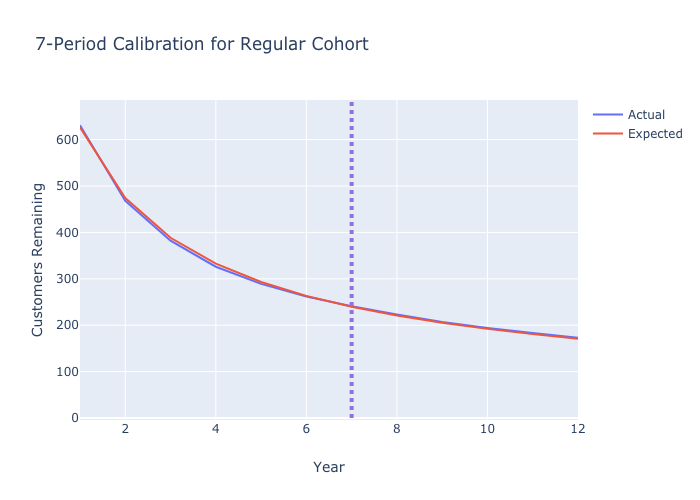

In [14]:
Image(filename='../images/sBG-figure-1.png')

In [16]:
fig = go.Figure()

fig.add_trace(
   go.Scatter(
       x=highend_df['Year'],
       y=highend_df['Highend'],
       mode='lines',
       name='Actual'
   )
)

fig.add_trace(
   go.Scatter(
       x=highend_df['Year'],
       y=highend_df['Expected'],
       mode='lines',
       name='Expected'
   )
)
 

fig.update_layout(title='7-Period Calibration for Highend Cohort',
                  xaxis_title='Year',
                  yaxis_title='Customers Remaining',
                  shapes=[
                      go.layout.Shape(
                        type="line",
                        x0='7',
                        y0=0,
                        x1='7',
                        y1=900,
                        line=dict(
                            color="MediumPurple",
                            width=4,
                            dash="dot",
                            ))
                  ]
                 )
fig.show()

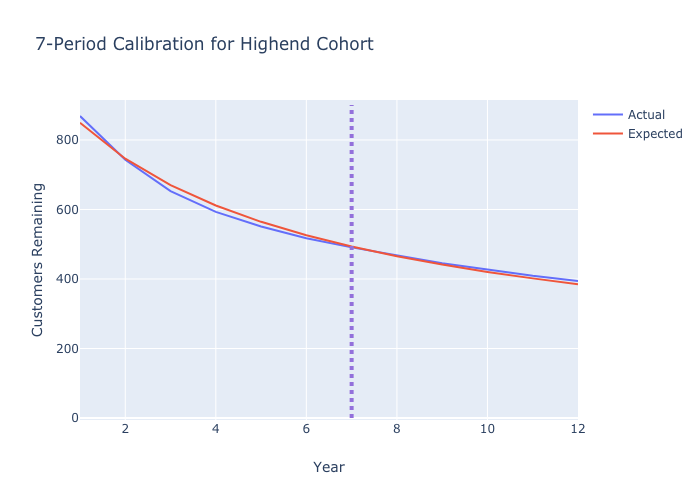

In [17]:
Image(filename='../images/sBG-figure-2.png')